In [2]:
import neo
import h5py
import torch
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import quantities as pq
from elephant.gpfa import GPFA

In [3]:
# ---- Convert to neo.SpikeTrains ---- #
def array_to_spiketrains(array, bin_size):
    """Convert B x T x N spiking array to list of list of SpikeTrains"""
    stList = []

    for trial in range(len(array)):
        trialList = []
        for channel in range(array.shape[2]):
            times = np.nonzero(array[trial, :, channel])[0]
            counts = array[trial, times, channel].astype(int)
            times = np.repeat(times, counts)
            st = neo.SpikeTrain(times*bin_size*pq.ms, t_stop=array.shape[1]*bin_size*pq.ms)
            trialList.append(st)
        stList.append(trialList)
    return stList

In [4]:
# load and prepare data
data = h5py.File('data/poisson_obs.h5')

Y = np.array(data['Y'])
X = np.array(data['X'])
C = np.array(data['C'])
b = np.array(data['bias'])

# setup parameters
n_trials = 100
bin_size_ms = 5
time_delta = bin_size_ms * 1e-3

n_latents = X.shape[2]
n_neurons = Y.shape[2]
n_time_bins = Y.shape[1]

Y = Y[:n_trials]
X = X[:n_trials]
Y_st_train = array_to_spiketrains(Y, bin_size_ms)

In [10]:
# ---- Run GPFA ---- #
gpfa = GPFA(bin_size=(bin_size_ms * pq.ms), x_dim=n_latents)
gpfa_val_result = gpfa.fit_transform(Y_st_train)

length_scales = gpfa.params_estimated['gamma']

Initializing parameters using factor analysis...

Fitting GPFA model...
Fitting has converged after 360 EM iterations.)


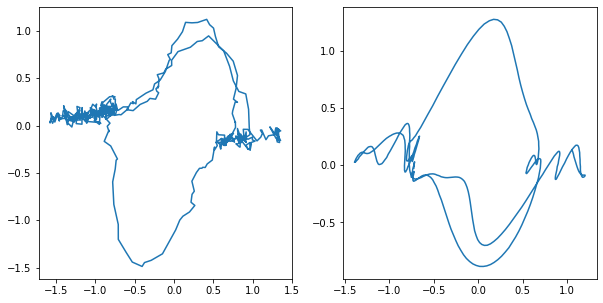

In [14]:
# plot the true and inferred latents of trial 0
trial_num = 1
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(10,5))
_= ax0.plot(X[trial_num,:,0], X[trial_num,:,1])
_= ax1.plot(gpfa_val_result[trial_num][0,:], gpfa_val_result[trial_num][1,:])